In [1]:
# File: colab_goemotions_finetune.py


import kagglehub
import os
import json
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments)
from peft import get_peft_config, LoraConfig, PeftModel
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from datasets import load_dataset

ds = load_dataset("google-research-datasets/go_emotions", "simplified")

In [3]:
# Function to convert numeric labels to text
def convert_labels_to_one_int(example):
    #text_labels = [label_mapping[label] for label in example["labels"]]
    example["labels"] = example["labels"][0]
    return example

# Assuming `dataset` is your DatasetDict
dataset = DatasetDict({
    "train": ds["train"].map(convert_labels_to_one_int),
    "validation": ds["validation"].map(convert_labels_to_one_int),
    "test": ds["test"].map(convert_labels_to_one_int),
})



"""# Assuming you have already loaded the DatasetDict as `dataset`
dataset = DatasetDict({
    "train": dataset["test"],         # Swap test with train
    "validation": dataset["validation"],  # Keep validation as is
    "test": dataset["train"]          # Swap train with test
})"""

'# Assuming you have already loaded the DatasetDict as `dataset`\ndataset = DatasetDict({\n    "train": dataset["test"],         # Swap test with train\n    "validation": dataset["validation"],  # Keep validation as is\n    "test": dataset["train"]          # Swap train with test\n})'

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [5]:
def preprocess_labels(example):
    example['labels'] = max(0, min(example['labels'], 27))  # Ensure labels are within range
    return example

dataset = dataset.map(preprocess_labels)

In [6]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
models = {
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=28, cache_dir="./models"),
        "size": "750MB"
    }
}




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
"""
# Prepare the dataset for training
def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)

# Prepare the tokenizers with padding token
tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Ensure each tokenizer has a padding token
for model_name, tokenizer in tokenizers.items():
    if tokenizer.pad_token is None:
        if tokenizer.eos_token:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})


# Models for fine-tuning
models = {
    "gpt2": {
        "path": "gpt2",
        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),
        "size": "500MB"
    },
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=27, cache_dir="./models"),
        "size": "750MB"
    },
    "roberta": {
        "path": "roberta-base",
        "model": AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=27, cache_dir="./models"),
        "size": "1GB"
    }
}
"""

'\n# Prepare the dataset for training\ndef preprocess_function(example, tokenizer, max_length=128):\n    return tokenizer(example[\'text\'], truncation=True, padding=\'max_length\', max_length=max_length)\n\n# Prepare the tokenizers with padding token\ntokenizers = {\n    "gpt2": AutoTokenizer.from_pretrained("gpt2"),\n    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),\n    "roberta": AutoTokenizer.from_pretrained("roberta-base"),\n}\n\n# Ensure each tokenizer has a padding token\nfor model_name, tokenizer in tokenizers.items():\n    if tokenizer.pad_token is None:\n        if tokenizer.eos_token:\n            tokenizer.pad_token = tokenizer.eos_token\n        else:\n            tokenizer.add_special_tokens({\'pad_token\': \'[PAD]\'})\n\n\n# Models for fine-tuning\nmodels = {\n    "gpt2": {\n        "path": "gpt2",\n        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),\n        "size": "500MB"\n    },\n    "distilbert": {\n       

In [8]:
def train_model(model_name, model, tokenizer, dataset, training_args, lora=False):
    if lora:
        print(f"Applying QLoRA to {model_name}...")
        # Dynamically set target modules based on the model type
        if model_name == "distilbert":
            target_modules = ["ffn.lin1", "ffn.lin2"]
        elif model_name == "roberta":
            target_modules = ["intermediate.dense", "output.dense"]
        elif model_name == "gpt2":
            target_modules = ["c_fc", "c_proj"]
        else:
            raise ValueError(f"LoRA target modules not defined for {model_name}")

        config = LoraConfig(
            r=16, lora_alpha=32, lora_dropout=0.1, target_modules=target_modules
        )
        model = PeftModel(model, config)

        # Freeze base model parameters
        for param in model.base_model.parameters():
            param.requires_grad = False
        print("Base model parameters frozen.")

        # Ensure LoRA parameters are trainable
        for name, param in model.named_parameters():
            if 'lora' in name:  # LoRA layers will have 'lora' in their names
                param.requires_grad = True
        print("LoRA parameters are trainable.")

    dataset = dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    dataset = dataset.remove_columns(['id'])  # Adjust as per GoEmotions structure
    from transformers import TrainerCallback
    import json
    from sklearn.metrics import accuracy_score
    import numpy as np

    # Define the compute_metrics function
    def compute_metrics(pred):
        logits, labels = pred
        predictions = np.argmax(logits, axis=-1)

        # Calculate accuracy
        accuracy = accuracy_score(labels, predictions)

        # Calculate the loss (use the loss function used during training)
        # Here we're using CrossEntropyLoss as an example
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(torch.tensor(logits), torch.tensor(labels)).item()  # Calculate loss

        return {"accuracy": accuracy, "loss": loss}


    class LogMetricsCallback(TrainerCallback):
        def __init__(self, log_dir="./logs/log_history_real_train_data.json"):
            self.log_dir = log_dir
            self.logs = []

        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs:
                log_entry = {
                    "epoch": logs.get("epoch"),
                    "train_loss": logs.get("loss"),
                    "learning_rate": logs.get("learning_rate"),
                    "grad_norm": logs.get("grad_norm", None),  # Gradient norm (if available)
                    "eval_loss": logs.get("eval_loss", None),  # Eval loss
                    "eval_accuracy": logs.get("eval_accuracy", None),  # Eval accuracy
                    "optimizer_state": logs.get("optimizer_state", None)  # Optimizer state (if available)
                }
                self.logs.append(log_entry)
                
                # Save logs to a file after each logging step
                with open(self.log_dir, "w") as f:
                    json.dump(self.logs, f, indent=4)


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[LogMetricsCallback(log_dir="./logs/log_history.json")]  # Custom callback
    )
    trainer.train()
    return trainer


# Metrics computation
accuracy_metric = evaluate.load("accuracy")

"""def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc}"""



'def compute_metrics(pred):\n    logits, labels = pred\n    predictions = np.argmax(logits, axis=-1)\n    acc = accuracy_metric.compute(predictions=predictions, references=labels)\n    return {"accuracy": acc}'

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
models = {
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=28, cache_dir="./models"),
        "size": "750MB"
    }
}




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [12]:
import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer

# Enable CUDA launch blocking for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"



# Training configurations
training_args = TrainingArguments(
    output_dir="./results_real_data",
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=False,
    logging_first_step=False,  # Make sure logs are being stored
    load_best_model_at_end=True, # Load the best model based on eval_loss
    metric_for_best_model="eval_loss",  # Use eval_loss to select the best model
    greater_is_better=False,  # Lower loss is better
)

# Train the model "distilbert"
model_name = "distilbert"
model_info = models[model_name]
print(f"Training {model_name} ({model_info['size']}) with standard fine-tuning...")

# Track the best model based on eval_loss and eval_accuracy
best_eval_loss = float("inf")
best_eval_accuracy = 0
best_model = None

# Assuming train_model is a function that handles the actual training and returns a Trainer object
trainer = train_model(model_name, model_info["model"], tokenizers[model_name], dataset, training_args, lora=False)

# Train the model
#trainer.train()

# Access the best model
best_model = trainer.model

# Save the best model
trainer.save_model("./best_model")

# After training, print the final evaluation and confusion matrix
eval_metrics = trainer.evaluate()
train_metrics = trainer.state.log_history[-1]  # Assuming the last logged metric is training loss

results = {
    'eval_loss': eval_metrics['eval_loss'],
    'train_loss': train_metrics.get('loss', None),  # Handle cases where loss may not be logged
    'trainer': trainer
}




c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training distilbert (750MB) with standard fine-tuning...


  0%|          | 0/27140 [00:00<?, ?it/s]

{'loss': 2.3188, 'grad_norm': 7.89373254776001, 'learning_rate': 1.9631540162122333e-05, 'epoch': 0.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.88994300365448, 'eval_accuracy': 0.47475119793586434, 'eval_runtime': 5.2855, 'eval_samples_per_second': 1026.579, 'eval_steps_per_second': 64.327, 'epoch': 0.18}
{'loss': 1.7392, 'grad_norm': 9.673247337341309, 'learning_rate': 1.926308032424466e-05, 'epoch': 0.37}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6097745895385742, 'eval_accuracy': 0.5398083302617029, 'eval_runtime': 5.4931, 'eval_samples_per_second': 987.783, 'eval_steps_per_second': 61.896, 'epoch': 0.37}
{'loss': 1.6089, 'grad_norm': 8.27371883392334, 'learning_rate': 1.8894620486366988e-05, 'epoch': 0.55}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5100555419921875, 'eval_accuracy': 0.5656100258016955, 'eval_runtime': 5.485, 'eval_samples_per_second': 989.24, 'eval_steps_per_second': 61.987, 'epoch': 0.55}
{'loss': 1.5369, 'grad_norm': 10.277700424194336, 'learning_rate': 1.8526160648489315e-05, 'epoch': 0.74}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4706155061721802, 'eval_accuracy': 0.5687430888315518, 'eval_runtime': 5.3562, 'eval_samples_per_second': 1013.037, 'eval_steps_per_second': 63.478, 'epoch': 0.74}
{'loss': 1.5156, 'grad_norm': 8.436522483825684, 'learning_rate': 1.8157700810611646e-05, 'epoch': 0.92}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4578782320022583, 'eval_accuracy': 0.562661260597125, 'eval_runtime': 5.5364, 'eval_samples_per_second': 980.054, 'eval_steps_per_second': 61.411, 'epoch': 0.92}
{'loss': 1.3978, 'grad_norm': 7.385414123535156, 'learning_rate': 1.7789240972733973e-05, 'epoch': 1.11}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4009400606155396, 'eval_accuracy': 0.5875414670106893, 'eval_runtime': 5.55, 'eval_samples_per_second': 977.664, 'eval_steps_per_second': 61.262, 'epoch': 1.11}
{'loss': 1.2975, 'grad_norm': 9.411633491516113, 'learning_rate': 1.74207811348563e-05, 'epoch': 1.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4157394170761108, 'eval_accuracy': 0.576852193144121, 'eval_runtime': 5.6972, 'eval_samples_per_second': 952.393, 'eval_steps_per_second': 59.678, 'epoch': 1.29}
{'loss': 1.3222, 'grad_norm': 8.337603569030762, 'learning_rate': 1.7052321296978632e-05, 'epoch': 1.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.3987033367156982, 'eval_accuracy': 0.5775893844452635, 'eval_runtime': 5.4534, 'eval_samples_per_second': 994.977, 'eval_steps_per_second': 62.347, 'epoch': 1.47}
{'loss': 1.3066, 'grad_norm': 11.446144104003906, 'learning_rate': 1.668386145910096e-05, 'epoch': 1.66}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.3976244926452637, 'eval_accuracy': 0.5786951713969776, 'eval_runtime': 5.6896, 'eval_samples_per_second': 953.674, 'eval_steps_per_second': 59.758, 'epoch': 1.66}
{'loss': 1.2589, 'grad_norm': 8.93756103515625, 'learning_rate': 1.6315401621223287e-05, 'epoch': 1.84}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.3914978504180908, 'eval_accuracy': 0.5788794692222632, 'eval_runtime': 5.6659, 'eval_samples_per_second': 957.652, 'eval_steps_per_second': 60.008, 'epoch': 1.84}
{'loss': 1.2765, 'grad_norm': 13.835762023925781, 'learning_rate': 1.5946941783345618e-05, 'epoch': 2.03}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4019720554351807, 'eval_accuracy': 0.5726133431625506, 'eval_runtime': 5.3877, 'eval_samples_per_second': 1007.117, 'eval_steps_per_second': 63.107, 'epoch': 2.03}
{'loss': 1.0926, 'grad_norm': 15.333020210266113, 'learning_rate': 1.5578481945467945e-05, 'epoch': 2.21}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4181874990463257, 'eval_accuracy': 0.5829340213785478, 'eval_runtime': 5.5698, 'eval_samples_per_second': 974.179, 'eval_steps_per_second': 61.043, 'epoch': 2.21}
{'loss': 1.0811, 'grad_norm': 9.341662406921387, 'learning_rate': 1.5210022107590274e-05, 'epoch': 2.39}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4355477094650269, 'eval_accuracy': 0.5774050866199779, 'eval_runtime': 5.4748, 'eval_samples_per_second': 991.095, 'eval_steps_per_second': 62.103, 'epoch': 2.39}
{'loss': 1.1059, 'grad_norm': 12.370981216430664, 'learning_rate': 1.4841562269712602e-05, 'epoch': 2.58}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.436362862586975, 'eval_accuracy': 0.5696645779579801, 'eval_runtime': 5.5195, 'eval_samples_per_second': 983.059, 'eval_steps_per_second': 61.6, 'epoch': 2.58}
{'loss': 1.0999, 'grad_norm': 9.6687650680542, 'learning_rate': 1.4473102431834931e-05, 'epoch': 2.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4352108240127563, 'eval_accuracy': 0.5683744931809804, 'eval_runtime': 5.2999, 'eval_samples_per_second': 1023.801, 'eval_steps_per_second': 64.153, 'epoch': 2.76}
{'loss': 1.0468, 'grad_norm': 11.715804100036621, 'learning_rate': 1.410464259395726e-05, 'epoch': 2.95}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4178667068481445, 'eval_accuracy': 0.5820125322521195, 'eval_runtime': 5.4499, 'eval_samples_per_second': 995.608, 'eval_steps_per_second': 62.386, 'epoch': 2.95}
{'loss': 0.9405, 'grad_norm': 11.55897045135498, 'learning_rate': 1.3736182756079588e-05, 'epoch': 3.13}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4690232276916504, 'eval_accuracy': 0.5722447475119794, 'eval_runtime': 5.4321, 'eval_samples_per_second': 998.885, 'eval_steps_per_second': 62.591, 'epoch': 3.13}
{'loss': 0.8608, 'grad_norm': 12.115300178527832, 'learning_rate': 1.3367722918201917e-05, 'epoch': 3.32}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5246531963348389, 'eval_accuracy': 0.5622926649465536, 'eval_runtime': 5.4566, 'eval_samples_per_second': 994.393, 'eval_steps_per_second': 62.31, 'epoch': 3.32}
{'loss': 0.8656, 'grad_norm': 16.120874404907227, 'learning_rate': 1.2999263080324244e-05, 'epoch': 3.5}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5026143789291382, 'eval_accuracy': 0.570770364909694, 'eval_runtime': 5.5011, 'eval_samples_per_second': 986.351, 'eval_steps_per_second': 61.806, 'epoch': 3.5}
{'loss': 0.8708, 'grad_norm': 15.245380401611328, 'learning_rate': 1.2630803242446574e-05, 'epoch': 3.68}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5046359300613403, 'eval_accuracy': 0.5737191301142647, 'eval_runtime': 5.4719, 'eval_samples_per_second': 991.618, 'eval_steps_per_second': 62.136, 'epoch': 3.68}
{'loss': 0.888, 'grad_norm': 16.037805557250977, 'learning_rate': 1.2262343404568904e-05, 'epoch': 3.87}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5219240188598633, 'eval_accuracy': 0.5694802801326945, 'eval_runtime': 5.5131, 'eval_samples_per_second': 984.203, 'eval_steps_per_second': 61.671, 'epoch': 3.87}
{'loss': 0.8143, 'grad_norm': 21.025545120239258, 'learning_rate': 1.1893883566691232e-05, 'epoch': 4.05}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5760575532913208, 'eval_accuracy': 0.5669001105786952, 'eval_runtime': 5.4294, 'eval_samples_per_second': 999.37, 'eval_steps_per_second': 62.622, 'epoch': 4.05}
{'loss': 0.6799, 'grad_norm': 21.36545753479004, 'learning_rate': 1.1525423728813561e-05, 'epoch': 4.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6212724447250366, 'eval_accuracy': 0.5586067084408404, 'eval_runtime': 5.63, 'eval_samples_per_second': 963.757, 'eval_steps_per_second': 60.39, 'epoch': 4.24}
{'loss': 0.6717, 'grad_norm': 7.996577262878418, 'learning_rate': 1.1156963890935889e-05, 'epoch': 4.42}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6621252298355103, 'eval_accuracy': 0.5554736454109841, 'eval_runtime': 5.6597, 'eval_samples_per_second': 958.702, 'eval_steps_per_second': 60.073, 'epoch': 4.42}
{'loss': 0.6929, 'grad_norm': 12.149642944335938, 'learning_rate': 1.0788504053058218e-05, 'epoch': 4.61}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6726481914520264, 'eval_accuracy': 0.5527091780316993, 'eval_runtime': 5.3184, 'eval_samples_per_second': 1020.224, 'eval_steps_per_second': 63.929, 'epoch': 4.61}
{'loss': 0.6921, 'grad_norm': 19.760950088500977, 'learning_rate': 1.0420044215180547e-05, 'epoch': 4.79}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6861375570297241, 'eval_accuracy': 0.5606339845189827, 'eval_runtime': 5.5659, 'eval_samples_per_second': 974.859, 'eval_steps_per_second': 61.086, 'epoch': 4.79}
{'loss': 0.6918, 'grad_norm': 22.833200454711914, 'learning_rate': 1.0051584377302874e-05, 'epoch': 4.97}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6864755153656006, 'eval_accuracy': 0.5549207519351271, 'eval_runtime': 5.5269, 'eval_samples_per_second': 981.75, 'eval_steps_per_second': 61.518, 'epoch': 4.97}
{'loss': 0.5476, 'grad_norm': 19.809152603149414, 'learning_rate': 9.683124539425204e-06, 'epoch': 5.16}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.7966440916061401, 'eval_accuracy': 0.5383339476594177, 'eval_runtime': 5.4853, 'eval_samples_per_second': 989.181, 'eval_steps_per_second': 61.983, 'epoch': 5.16}
{'loss': 0.5125, 'grad_norm': 11.556180000305176, 'learning_rate': 9.314664701547533e-06, 'epoch': 5.34}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8197780847549438, 'eval_accuracy': 0.5385182454847033, 'eval_runtime': 5.3436, 'eval_samples_per_second': 1015.429, 'eval_steps_per_second': 63.628, 'epoch': 5.34}
{'loss': 0.5268, 'grad_norm': 18.259469985961914, 'learning_rate': 8.94620486366986e-06, 'epoch': 5.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8467555046081543, 'eval_accuracy': 0.5416513085145596, 'eval_runtime': 5.5975, 'eval_samples_per_second': 969.355, 'eval_steps_per_second': 60.741, 'epoch': 5.53}
{'loss': 0.5335, 'grad_norm': 25.032251358032227, 'learning_rate': 8.57774502579219e-06, 'epoch': 5.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8697150945663452, 'eval_accuracy': 0.548470328050129, 'eval_runtime': 5.516, 'eval_samples_per_second': 983.685, 'eval_steps_per_second': 61.639, 'epoch': 5.71}
{'loss': 0.5163, 'grad_norm': 30.470443725585938, 'learning_rate': 8.209285187914517e-06, 'epoch': 5.9}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8762688636779785, 'eval_accuracy': 0.5464430519719867, 'eval_runtime': 5.2969, 'eval_samples_per_second': 1024.372, 'eval_steps_per_second': 64.188, 'epoch': 5.9}
{'loss': 0.4642, 'grad_norm': 7.964538097381592, 'learning_rate': 7.840825350036846e-06, 'epoch': 6.08}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.9266059398651123, 'eval_accuracy': 0.5444157758938445, 'eval_runtime': 5.3725, 'eval_samples_per_second': 1009.951, 'eval_steps_per_second': 63.285, 'epoch': 6.08}
{'loss': 0.3925, 'grad_norm': 19.526071548461914, 'learning_rate': 7.472365512159175e-06, 'epoch': 6.26}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.9714545011520386, 'eval_accuracy': 0.549576115001843, 'eval_runtime': 5.4682, 'eval_samples_per_second': 992.283, 'eval_steps_per_second': 62.178, 'epoch': 6.26}
{'loss': 0.3967, 'grad_norm': 13.724432945251465, 'learning_rate': 7.103905674281504e-06, 'epoch': 6.45}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.0247271060943604, 'eval_accuracy': 0.5405455215628455, 'eval_runtime': 5.5084, 'eval_samples_per_second': 985.032, 'eval_steps_per_second': 61.723, 'epoch': 6.45}
{'loss': 0.3905, 'grad_norm': 10.490452766418457, 'learning_rate': 6.735445836403832e-06, 'epoch': 6.63}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.0609633922576904, 'eval_accuracy': 0.5418356063398452, 'eval_runtime': 5.2859, 'eval_samples_per_second': 1026.497, 'eval_steps_per_second': 64.322, 'epoch': 6.63}
{'loss': 0.4005, 'grad_norm': 22.19747543334961, 'learning_rate': 6.36698599852616e-06, 'epoch': 6.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.0691213607788086, 'eval_accuracy': 0.5339107998525617, 'eval_runtime': 5.3672, 'eval_samples_per_second': 1010.961, 'eval_steps_per_second': 63.348, 'epoch': 6.82}
{'loss': 0.4192, 'grad_norm': 16.454126358032227, 'learning_rate': 5.99852616064849e-06, 'epoch': 7.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.074456214904785, 'eval_accuracy': 0.5352008846295614, 'eval_runtime': 5.529, 'eval_samples_per_second': 981.373, 'eval_steps_per_second': 61.494, 'epoch': 7.0}
{'loss': 0.3155, 'grad_norm': 14.08533000946045, 'learning_rate': 5.630066322770819e-06, 'epoch': 7.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.1342952251434326, 'eval_accuracy': 0.536490969406561, 'eval_runtime': 5.4355, 'eval_samples_per_second': 998.245, 'eval_steps_per_second': 62.551, 'epoch': 7.18}
{'loss': 0.3094, 'grad_norm': 9.676865577697754, 'learning_rate': 5.261606484893147e-06, 'epoch': 7.37}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.1553475856781006, 'eval_accuracy': 0.5339107998525617, 'eval_runtime': 5.3656, 'eval_samples_per_second': 1011.262, 'eval_steps_per_second': 63.367, 'epoch': 7.37}
{'loss': 0.3058, 'grad_norm': 17.99992561340332, 'learning_rate': 4.893146647015476e-06, 'epoch': 7.55}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.1947216987609863, 'eval_accuracy': 0.5340950976778474, 'eval_runtime': 5.4857, 'eval_samples_per_second': 989.111, 'eval_steps_per_second': 61.979, 'epoch': 7.55}
{'loss': 0.3154, 'grad_norm': 14.68044376373291, 'learning_rate': 4.524686809137805e-06, 'epoch': 7.74}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.224478244781494, 'eval_accuracy': 0.5298562476962771, 'eval_runtime': 5.6005, 'eval_samples_per_second': 968.844, 'eval_steps_per_second': 60.709, 'epoch': 7.74}
{'loss': 0.3026, 'grad_norm': 13.312865257263184, 'learning_rate': 4.156226971260133e-06, 'epoch': 7.92}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.2364554405212402, 'eval_accuracy': 0.535385182454847, 'eval_runtime': 5.2545, 'eval_samples_per_second': 1032.639, 'eval_steps_per_second': 64.706, 'epoch': 7.92}
{'loss': 0.288, 'grad_norm': 6.819782257080078, 'learning_rate': 3.7877671333824617e-06, 'epoch': 8.11}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.2736432552337646, 'eval_accuracy': 0.53483228897899, 'eval_runtime': 5.3937, 'eval_samples_per_second': 1005.983, 'eval_steps_per_second': 63.036, 'epoch': 8.11}
{'loss': 0.234, 'grad_norm': 9.941829681396484, 'learning_rate': 3.41930729550479e-06, 'epoch': 8.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3177602291107178, 'eval_accuracy': 0.5315149281238482, 'eval_runtime': 5.5018, 'eval_samples_per_second': 986.22, 'eval_steps_per_second': 61.798, 'epoch': 8.29}
{'loss': 0.2367, 'grad_norm': 16.21933937072754, 'learning_rate': 3.0508474576271192e-06, 'epoch': 8.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3534128665924072, 'eval_accuracy': 0.5429413932915591, 'eval_runtime': 5.7286, 'eval_samples_per_second': 947.171, 'eval_steps_per_second': 59.351, 'epoch': 8.47}
{'loss': 0.265, 'grad_norm': 13.422394752502441, 'learning_rate': 2.6823876197494476e-06, 'epoch': 8.66}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3533010482788086, 'eval_accuracy': 0.5316992259491338, 'eval_runtime': 5.5291, 'eval_samples_per_second': 981.349, 'eval_steps_per_second': 61.493, 'epoch': 8.66}
{'loss': 0.2517, 'grad_norm': 17.26520347595215, 'learning_rate': 2.3139277818717763e-06, 'epoch': 8.84}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3681082725524902, 'eval_accuracy': 0.5324364172502765, 'eval_runtime': 5.3893, 'eval_samples_per_second': 1006.802, 'eval_steps_per_second': 63.087, 'epoch': 8.84}
{'loss': 0.2396, 'grad_norm': 12.626238822937012, 'learning_rate': 1.9454679439941047e-06, 'epoch': 9.03}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3757705688476562, 'eval_accuracy': 0.5344636933284187, 'eval_runtime': 5.5244, 'eval_samples_per_second': 982.182, 'eval_steps_per_second': 61.545, 'epoch': 9.03}
{'loss': 0.2038, 'grad_norm': 12.274667739868164, 'learning_rate': 1.5770081061164336e-06, 'epoch': 9.21}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.385061264038086, 'eval_accuracy': 0.5346479911537044, 'eval_runtime': 5.3066, 'eval_samples_per_second': 1022.496, 'eval_steps_per_second': 64.071, 'epoch': 9.21}
{'loss': 0.2196, 'grad_norm': 6.573563575744629, 'learning_rate': 1.2085482682387622e-06, 'epoch': 9.4}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3883798122406006, 'eval_accuracy': 0.5346479911537044, 'eval_runtime': 5.6611, 'eval_samples_per_second': 958.476, 'eval_steps_per_second': 60.059, 'epoch': 9.4}
{'loss': 0.2163, 'grad_norm': 30.78411102294922, 'learning_rate': 8.400884303610906e-07, 'epoch': 9.58}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.395968198776245, 'eval_accuracy': 0.5346479911537044, 'eval_runtime': 5.4915, 'eval_samples_per_second': 988.078, 'eval_steps_per_second': 61.914, 'epoch': 9.58}
{'loss': 0.2062, 'grad_norm': 18.714767456054688, 'learning_rate': 4.7162859248341935e-07, 'epoch': 9.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3994128704071045, 'eval_accuracy': 0.5322521194249907, 'eval_runtime': 5.5068, 'eval_samples_per_second': 985.334, 'eval_steps_per_second': 61.742, 'epoch': 9.76}
{'loss': 0.1994, 'grad_norm': 7.587258815765381, 'learning_rate': 1.0316875460574797e-07, 'epoch': 9.95}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.4052960872650146, 'eval_accuracy': 0.5346479911537044, 'eval_runtime': 5.4854, 'eval_samples_per_second': 989.179, 'eval_steps_per_second': 61.983, 'epoch': 9.95}
{'train_runtime': 1855.2321, 'train_samples_per_second': 233.987, 'train_steps_per_second': 14.629, 'train_loss': 0.7359442239310167, 'epoch': 10.0}


  0%|          | 0/340 [00:00<?, ?it/s]

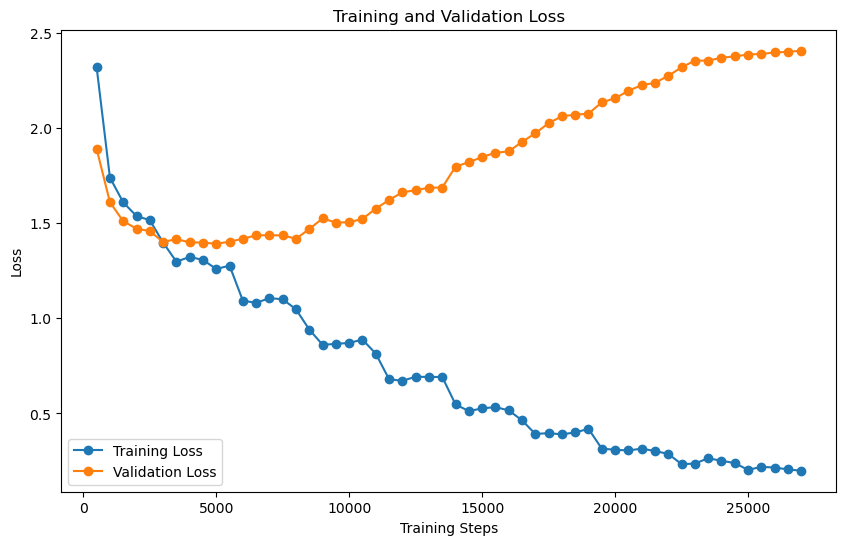

In [15]:
import matplotlib.pyplot as plt

# Extract the log history from the Trainer
logs = trainer.state.log_history

# Prepare data for plotting
train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
steps = [entry['step'] for entry in logs if 'step' in entry and 'loss' in entry]
eval_loss = eval_loss[0:-1]
# Plot training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", marker='o')
plt.plot(steps, eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('training_and_val_loss_distilbert_best_model_10_epochs.pdf')
plt.show()

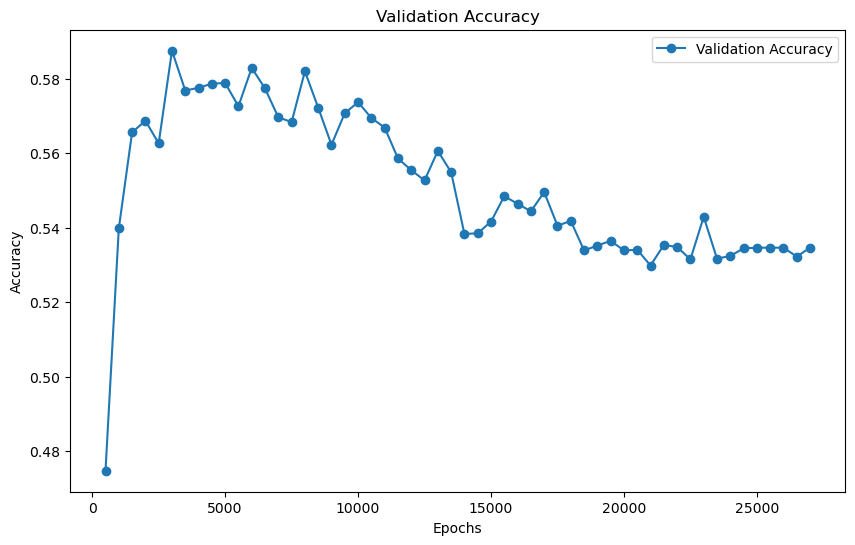

In [19]:
# Assuming you logged 'eval_accuracy' during training
eval_accuracy = [entry['eval_accuracy'] for entry in logs if 'eval_accuracy' in entry]
eval_accuracy = eval_accuracy[:-1]
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(steps, eval_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.savefig('validation_accuracy_distilbert_best_model_10_epochs.pdf')
plt.show()


In [17]:
"""# Generate confusion matrix for "distilbert"
print(f"Evaluating {model_name} on the test dataset...")

# Make predictions on the test set
predictions = trainer.predict(dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Print and plot the confusion matrix
print("Classification Report:")
print(classification_report(true_labels, preds))

labels = list(set(true_labels))  # Assuming labels are numeric and continuous
tokenized_inputs = tokenizer(
    raw_texts,
    padding=True,          # Pad to the longest sequence in the batch
    truncation=True,       # Truncate sequences to the model's max length
    max_length=128,        # Set max length explicitly
    return_tensors="pt"    # Return PyTorch tensors
)plot_confusion_matrix(true_labels, preds, labels, title=f"Confusion Matrix for {model_name}")"""

'# Generate confusion matrix for "distilbert"\nprint(f"Evaluating {model_name} on the test dataset...")\n\n# Make predictions on the test set\npredictions = trainer.predict(dataset["test"])\npreds = np.argmax(predictions.predictions, axis=1)\ntrue_labels = predictions.label_ids\n\n# Print and plot the confusion matrix\nprint("Classification Report:")\nprint(classification_report(true_labels, preds))\n\nlabels = list(set(true_labels))  # Assuming labels are numeric and continuous\ntokenized_inputs = tokenizer(\n    raw_texts,\n    padding=True,          # Pad to the longest sequence in the batch\n    truncation=True,       # Truncate sequences to the model\'s max length\n    max_length=128,        # Set max length explicitly\n    return_tensors="pt"    # Return PyTorch tensors\n)plot_confusion_matrix(true_labels, preds, labels, title=f"Confusion Matrix for {model_name}")'

Load best model

In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Path to the saved model
model_path = "./best_model"  # Replace with your saved model's folder path

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenize the dataset
tokenized_dataset = dataset["train"].map(preprocess_function, batched=True)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

In [21]:
tokenized_dataset = tokenized_dataset.remove_columns(["id", "text"])  # Remove unnecessary columns
tokenized_dataset.set_format("torch")  # Convert to PyTorch tensors


In [22]:
import torch
from torch.utils.data import DataLoader

# DataLoader for the dataset
dataloader = DataLoader(tokenized_dataset, batch_size=8)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
all_predictions = []
all_labels = []
model.eval()
for batch in dataloader:
    # Move inputs and labels to the device
    inputs = {key: value.to(device) for key, value in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(dim=1)

        # Collect predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print results
print("Predictions:", all_predictions)
print("True Labels:", all_labels)


Predictions: [27, 27, 2, 14, 2, 26, 15, 8, 0, 27, 6, 1, 27, 5, 3, 3, 15, 2, 27, 6, 27, 3, 27, 27, 27, 2, 27, 25, 15, 27, 2, 6, 3, 2, 7, 17, 27, 0, 25, 27, 0, 15, 27, 9, 7, 10, 20, 1, 27, 27, 27, 27, 27, 17, 0, 10, 27, 3, 26, 15, 0, 12, 27, 0, 27, 0, 27, 1, 27, 0, 27, 5, 3, 27, 7, 27, 0, 0, 27, 1, 13, 4, 24, 27, 27, 25, 15, 27, 4, 27, 27, 27, 24, 18, 4, 27, 7, 27, 7, 27, 0, 3, 27, 27, 27, 5, 27, 7, 0, 15, 7, 0, 9, 27, 17, 3, 2, 2, 7, 27, 27, 27, 27, 2, 2, 26, 26, 2, 27, 15, 15, 27, 11, 1, 3, 27, 7, 14, 27, 3, 3, 13, 27, 27, 18, 9, 17, 15, 1, 1, 1, 15, 7, 27, 7, 27, 0, 27, 0, 7, 15, 0, 2, 27, 27, 27, 0, 22, 14, 7, 18, 27, 20, 27, 27, 0, 27, 6, 17, 27, 3, 7, 15, 13, 0, 3, 27, 27, 27, 7, 27, 2, 27, 10, 15, 0, 27, 27, 27, 18, 8, 7, 7, 9, 4, 10, 27, 15, 27, 27, 0, 18, 27, 6, 27, 26, 27, 26, 27, 25, 0, 20, 25, 15, 0, 20, 7, 5, 27, 27, 3, 17, 27, 11, 27, 4, 27, 8, 27, 17, 20, 3, 7, 27, 10, 3, 4, 4, 27, 1, 0, 27, 9, 10, 27, 24, 27, 7, 27, 1, 7, 27, 5, 27, 9, 27, 3, 1, 18, 1, 27, 27, 15, 8, 27, 

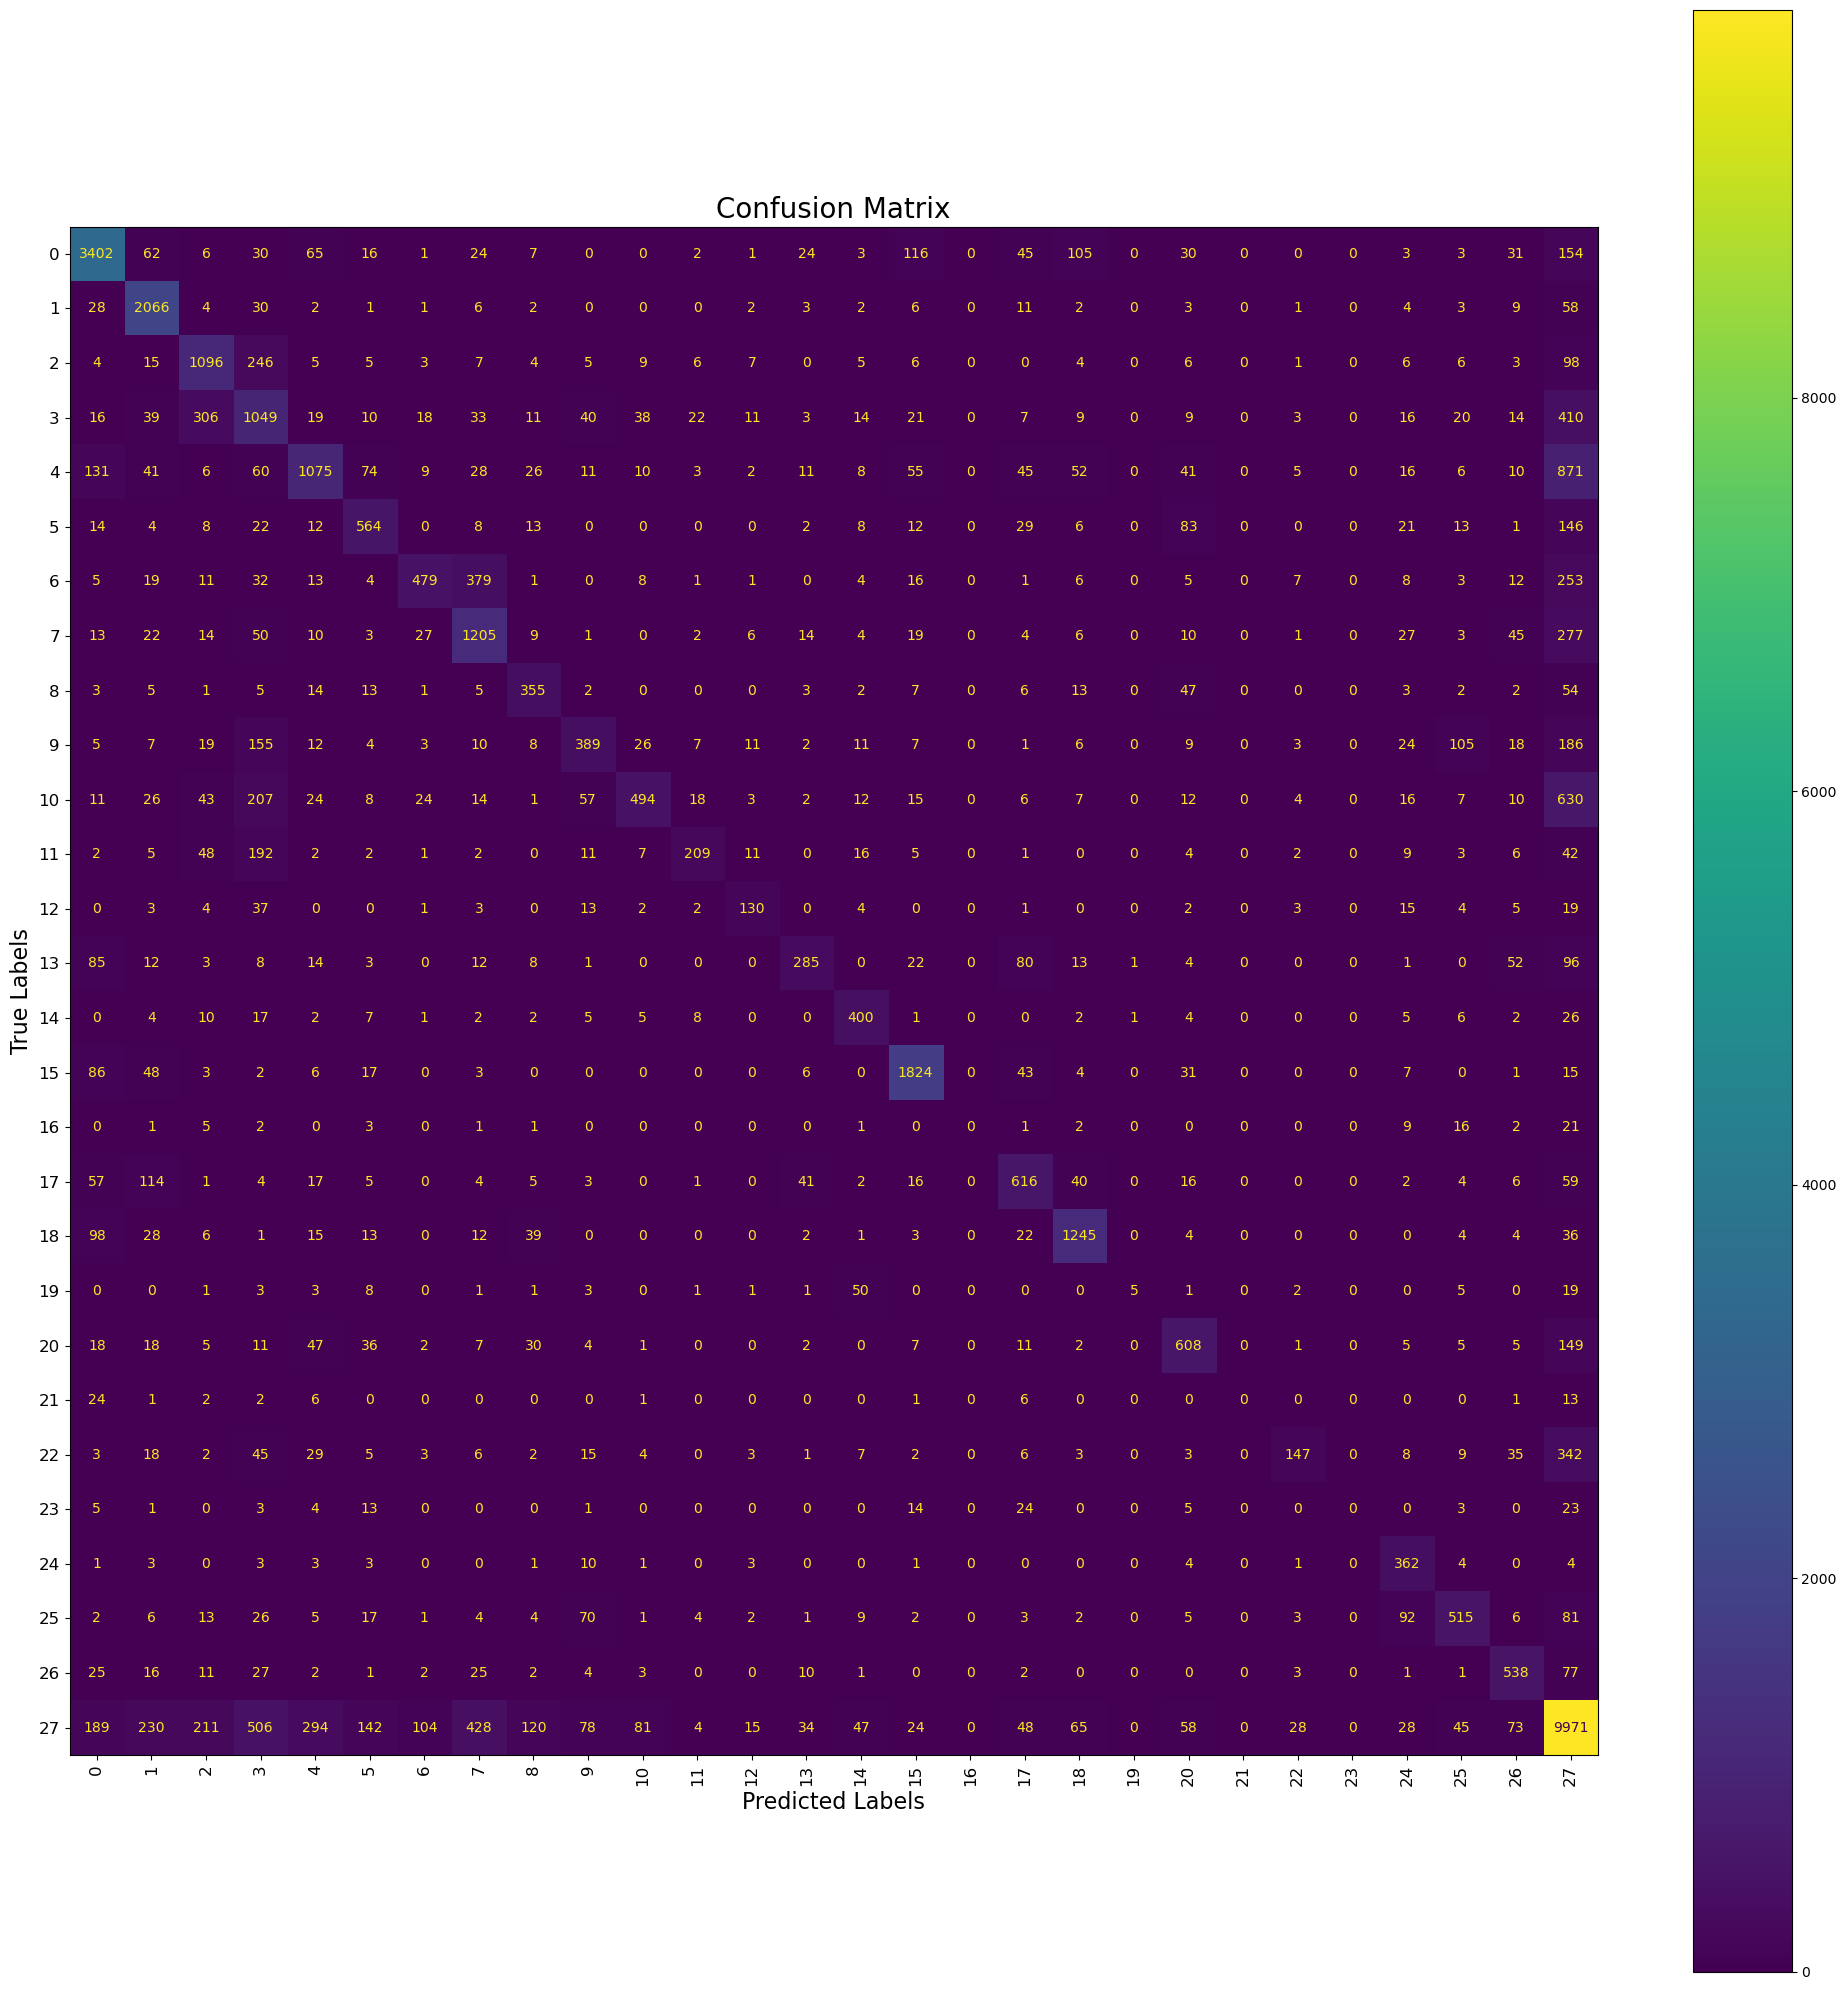

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Increase figure size and adjust font
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figsize for large matrix

# Use class labels for better interpretability (update if your model doesn't have `id2label`)
class_labels = model.config.id2label if hasattr(model.config, "id2label") else [str(i) for i in range(len(cm))]

# Display confusion matrix with larger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, xticks_rotation='vertical')  # Rotate labels if needed

# Adjust font sizes for clarity
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig('confusion_matrix_distilbert_best_model_10_epochs.pdf')
plt.show()


In [24]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions))


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4130
           1       0.73      0.92      0.82      2244
           2       0.60      0.71      0.65      1547
           3       0.38      0.49      0.43      2138
           4       0.63      0.41      0.50      2596
           5       0.58      0.58      0.58       966
           6       0.70      0.38      0.49      1268
           7       0.54      0.68      0.60      1772
           8       0.54      0.65      0.59       543
           9       0.54      0.38      0.44      1028
          10       0.71      0.30      0.42      1651
          11       0.72      0.36      0.48       580
          12       0.62      0.52      0.57       248
          13       0.64      0.41      0.50       700
          14       0.65      0.78      0.71       510
          15       0.83      0.87      0.85      2096
          16       0.00      0.00      0.00        65
          17       0.60    

c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# Now, find where the predictions were 'x' but the actual labels were 'y'
# Define the class labels you are interested in (e.g., predicted as 'x' and actual 'y')
x = 6  # Predicted as 'x'
y = 7  # Actual label 'y'

# Extract the texts where prediction is 'x' but the actual label is 'y'
incorrect_texts = [text for pred, true, text in zip(all_predictions, all_labels, dataset["train"]) if pred == x and true == y]

# Print or save the incorrect texts
print(incorrect_texts)

[{'text': 'Maybe it’s a cultural thing? That’s the way we do it in (I assume from my experience) Canada.', 'labels': 7, 'id': 'ee9acg5'}, {'text': 'No. You seem to still be completely misunderstanding what memory conformity is. Are you familiar with the process as documented in the peer-reviewed literature?', 'labels': 7, 'id': 'efehhok'}, {'text': "That must be it? Or that people buy carbon dioxide as plant food? I'm terrible at science and even I know it's not that simple", 'labels': 7, 'id': 'edll7nz'}, {'text': 'I don’t think it was a freestyle? So not really comparable?', 'labels': 7, 'id': 'edb3zix'}, {'text': 'Why else? Seems that it is just lack of imagination on your part.', 'labels': 7, 'id': 'ee8xgzm'}, {'text': 'How is it racist? I fail to see how.', 'labels': 7, 'id': 'ef7huei'}, {'text': "I have the same question I had before- you didn't attempt to explain why US healthcare prices ought be higher than Canadian.", 'labels': 7, 'id': 'edp06dj'}, {'text': 'I don’t know the w

In [ ]:
"""import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForPreTraining

# Load tokenizer and model
model_path = "./results_real_data/checkpoint-27140"  # Update with your checkpoint path
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForPreTraining.from_pretrained(model_path)

# Map predictions to emotion labels
label_mapping = {
    0: "admiration",
    1: "amusement",
    2: "anger",
    3: "annoyance",
    4: "approval",
    5: "caring",
    6: "confusion",
    7: "curiosity",
    8: "desire",
    9: "disappointment",
    10: "disapproval",
    11: "disgust",
    12: "embarrassment",
    13: "excitement",
    14: "fear",
    15: "gratitude",
    16: "grief",
    17: "joy",
    18: "love",
    19: "nervousness",
    20: "optimism",
    21: "pride",
    22: "realization",
    23: "relief",
    24: "remorse",
    25: "sadness",
    26: "surprise",
    27: "neutral"  # Include "neutral" if applicable
}
"""